In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from __future__ import annotations
import numpy as np
import scipy

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 6 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [7]:
data_bz_all = data["b2dz"]
print(data_bz_all.shape)

data_bz = data_bz_all[60:240, 280:490]
print(data_bz.shape)

(256, 512)
(180, 210)


In [8]:
nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm

nresol_z = 155

zmax_Mm = nresol_z * pixelsize_z_Mm

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 40.32 34.56 9.92
nresol_x, nresol_y, nresol_z 210 180 155
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [9]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

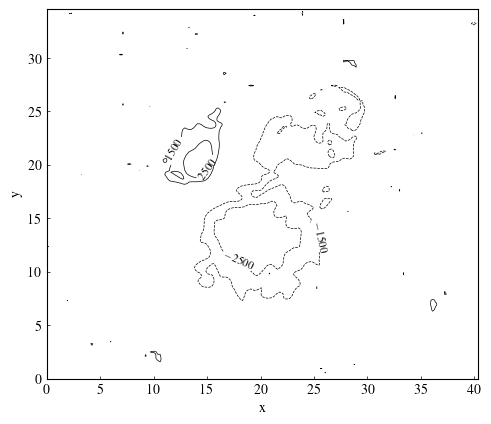

In [37]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# CS = ax.contour(
#     x_grid,
#     y_grid,
#     data2d.bz,
#     2,
#     colors='k',
#     linewidths=0.2,
# )
# #ax.grid(color="black", alpha=1.0, linestyle="dotted", linewidth=0.5)
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_box_aspect(ymax_Mm / xmax_Mm)
# ax.clabel(CS, fontsize=8, inline=True)
# ax.tick_params(direction="in", length=2, width=0.5)
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-2500, -1500, 1500, 2500)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(ymax_Mm / xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
# plotname = folder + "/contour2.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

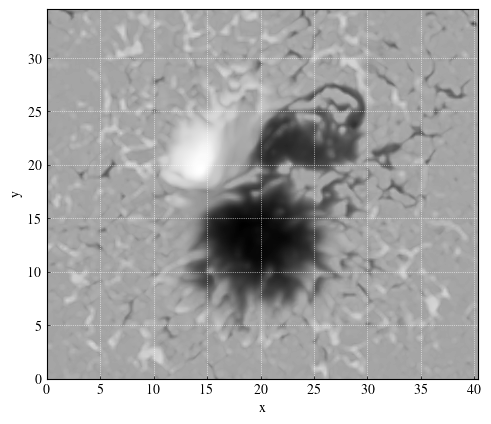

In [10]:
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(color="white", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.contourf(x_grid, y_grid, data2d.bz, 1000, cmap=cmap)
ax.set_box_aspect(data2d.y[-1] / data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
# plotname = folder + "/contour3.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [394]:
alpha = 0.077
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(k2_arr.min())
print(alpha**2)

print(limit.min())

0.006070978551233829
0.005929
-1.4532271280368885


In [15]:
path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

print(data3dref["info_unit"])
print(data3dref["info_pixel"])
print(data3dref["info_array"])

bx_ref = data3dref["b3dx"][:, 60:240, 280:490]
by_ref = data3dref["b3dy"][:, 60:240, 280:490]
bz_ref = data3dref["b3dz"][:, 60:240, 280:490]

pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

bx_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
by_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bz_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_rec = np.array((by_rec, bx_rec, bz_rec))
B_ref = np.array((issi_by, issi_bx, issi_bz))

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 8 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, d3d, p3d: magnetic vector (Gauss), plasma density (g/cm^3), plasma pressure (dyn/cm^2)'
b'Pixel spacing: 192km*192km*64km'
b'Array example: d3d(nx,ny,nz)'
(180, 210, 155)
(180, 210, 155

In [14]:
print(B_rec.shape)

(3, 180, 210, 652)


In [15]:
print(B_ref.shape)

(3, 180, 210, 652)


In [16]:
B_ref_See = np.zeros_like(data3d.field)

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

Data3dref = Field3dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    x_arr,
    y_arr,
    z_arr,
    data3d.bz,
    B_ref_See,
    np.zeros_like(B_ref_See),
    0,
    0,
    0,
    0,
    0,
    tanh=True,
)

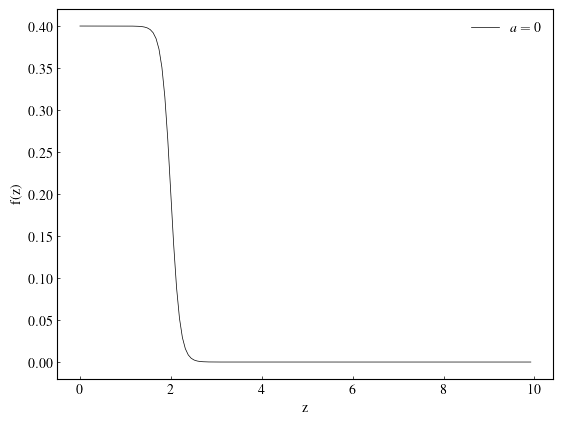

In [288]:
from mhsflex.switch import f, f_low

f1 = np.zeros(nresol_z)

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f1[iz] = f(z,2.0, 0.2, 0.2, 1.0)

plt.plot(
    z_arr,
    f1,
    label=r"$a = 0$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [408]:
data3d = calculate_magfield(data2d, 0.01, 1.0, 0.077, 30.0, 10.0)

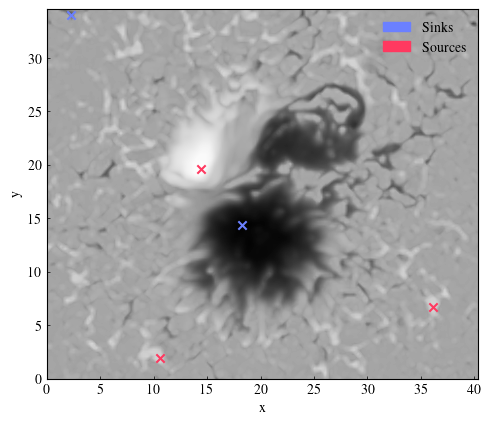

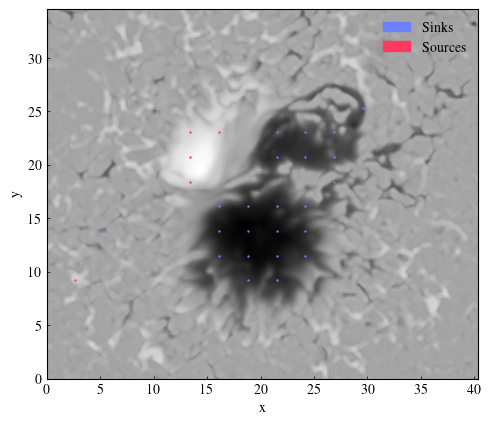

In [382]:
show_poles(data3d)
show_footpoints(data3d)